In [1]:
import random
import math
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from scipy.optimize import minimize
from scipy.stats import gamma, norm
import seaborn as sns
import time

from functools import partial

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
N = int(1e5)  # MC iterations
def _r(x): return np.round(x, 2)
def _CI(mu, std, n=1, z=1): return mu + (z/np.sqrt(n)) * np.array([-std, std])

# Variance reduction

As with any class of computational procedures, one has the ability to design Monte Carlo algorithms that can take judicious advantage of problem structure to enhance convergence. Such procedures are known as variance reduction techniques (VRT).

## Critical path method

The critical path method is widely used in project management settings to estimate the duration of a project, and to identify the “critical path” along which delays are most likely to slow down the completion of the project. The time required to complete the project can be viewed as the longest path from a source vertex (A) to sink vertex (B), in which the directed edge weights are the task duration times.

Suppose the task duration times $Z_1,\dots,Z_6$ are independent exponential r.v.’s with $EZ_i = i, 1 \leq i \leq 4$, and $EZ_5 = 15$, and $EZ_6 = 6$. Apply two different variance reduction methods to this problem to compute EL, the expected length of the longest path, and include approximate 90% confidence intervals.

Possible paths:
- $Z_1 \rightarrow Z_2 \rightarrow Z_4$
- $Z_1 \rightarrow Z_3$
- $Z_5 \rightarrow Z_6$

Clearly, the thris is the longest due to the high epxected values, so its correlation with $L$ should be high.



In [3]:
def Z_i(m): return np.random.exponential(m)

EZ = [1,2,3,4,15,6]

First, let's estimate a vanilla MC:

In [4]:
L = np.zeros(N)
for i in range(N):
  Z = np.array([Z_i(m) for m in EZ])
  path_1 = sum([Z[i-1] for i in [5,6]])
  path_2 = sum([Z[i-1] for i in [1,3]])
  path_3 = sum([Z[i-1] for i in [1,2,4]])
  L[i] = np.max([path_1, path_2, path_3])

mu = np.mean(L)
sigma = np.sqrt(sum((L - mu)**2) / (N - 1))
print('EL:', _r(mu))
print('CI:', _r(_CI(mu, sigma, n=N, z=1.645)))
print('Var(L):', _r(sigma**2))

EL: 21.95
CI: [21.87 22.03]
Var(L): 241.3


### Control Variate:

We can see that $Z_5$ is highly correlated with the longest path as it has the highest expected value. Choosing $W = Z_5 + Z_6$ should reduce the variance of our estiamtor. 

Thus, we set $C = W - EW$, where by linearity of expectation $EW = EZ_5 + EZ_6$.

EL: 21.78
CI: [21.77 21.79]
Reduced variance: 5.5151860682615395


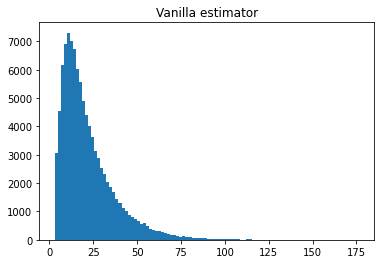

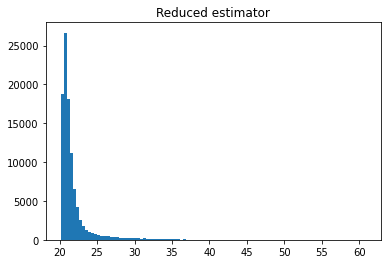

In [5]:
L = np.zeros(N)
W = np.zeros(N)

for i in range(N):
  Z = np.array([Z_i(m) for m in EZ])
  path_1 = sum([Z[i-1] for i in [5,6]])
  path_2 = sum([Z[i-1] for i in [1,3]])
  path_2 = sum([Z[i-1] for i in [1,2,4]])
  L[i] = np.max([path_1, path_2, path_3])
  W[i] = Z[5-1]+Z[6-1]

EW = EZ[5-1] + EZ[6-1]
C = W - EW
c = np.cov(np.array([L,C]))[0][1] / np.var(C)
Y = L - c*C
mu = np.mean(Y)
sigma = np.sqrt(np.sum((Y - mu)**2) / (N - 1))

print('EL:', _r(mu))
print('CI:', _r(_CI(mu, sigma, n=N, z=1.645)))
print('Reduced variance:', sigma**2)

plt.hist(L, bins=100)
plt.title('Vanilla estimator'); plt.show()

plt.hist(Y, bins=100)
plt.title('Reduced estimator'); plt.show()

### Antithetics

We use inverse transform sampling to draw exponential r.v..

For sample in $\frac{n}{2}$, we draw two exponentials, take the max path for each, and append the average of those two maximum paths.

In [6]:
def unif_generator(EZ):
  U = np.random.uniform()
  return -EZ * np.log(U), -EZ * np.log(1-U)

X = np.zeros(N//2)
for i in range(N//2):
  Z = np.array([unif_generator(m) for m in EZ])
  temp = np.zeros(2)
  for z in [0,1]:
    path1 = sum([Z[i-1][z] for i in [5,6]])
    path2 = sum([Z[i-1][z] for i in [1,3]])
    path3 = sum([Z[i-1][z] for i in [1,2,4]])
    temp[z] = np.max([path1, path2, path3])
  X[i] = np.mean(temp)

mu = np.mean(X)
sigma = np.sqrt(sum((X-mu)**2) / (N-1))
print('EL:', _r(mu))
print('CI:', _r(_CI(mu, sigma, n=N, z=1.645)))
print('Reduced variance:', sigma**2)

EL: 21.93
CI: [21.91 21.96]
Reduced variance: 27.807437645109406
